In [ ]:
!pip install --upgrade sympy

Binary class classification using pre-trained transformer Bert

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

df=pd.read_csv("/content/drive/MyDrive/pstat197a/claims_clean.csv")

label_encoder=LabelEncoder()
df['bclass_encoded']=label_encoder.fit_transform(df['bclass'])

train_texts, val_texts, train_labels, val_labels=train_test_split(
    df['text_clean'].tolist(),
    df['bclass_encoded'].tolist(),
    test_size=0.2,
    random_state=42
)

In [2]:
from transformers import AutoTokenizer

MODEL_NAME="bert-base-uncased"
tokenizer=AutoTokenizer.from_pretrained(MODEL_NAME)
train_texts=[str(text) for text in train_texts]
val_texts=[str(text) for text in val_texts]

train_encodings=tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings=tokenizer(val_texts, truncation=True, padding=True, max_length=512)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [3]:
import torch

class ClaimsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings=encodings
        self.labels=labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item={key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels']=torch.tensor(self.labels[idx])
        return item

train_dataset=ClaimsDataset(train_encodings, train_labels)
val_dataset=ClaimsDataset(val_encodings, val_labels)

In [4]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

model=AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

training_args=TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    save_total_limit=1,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",
)


from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels=pred.label_ids
    preds=pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc=accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

trainer=Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-4-827e7b40f3f2>:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer=Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.491000,0.455268,0.806075,0.799031,0.891892,0.723684
2,0.512900,0.398312,0.829439,0.846960,0.811245,0.885965
3,0.324100,0.450146,0.792056,0.791569,0.849246,0.741228
4,0.288100,0.389046,0.829439,0.841649,0.832618,0.850877
5,0.283200,0.480771,0.822430,0.840336,0.806452,0.877193
6,0.203700,0.515373,0.808411,0.822511,0.811966,0.833333
7,0.235200,0.597266,0.808411,0.830579,0.785156,0.881579
8,0.139300,0.619245,0.810748,0.830189,0.795181,0.868421
9,0.175600,0.616075,0.815421,0.828633,0.819742,0.837719
10,0.137000,0.620395,0.813084,0.826840,0.816239,0.837719


TrainOutput(global_step=1070, training_loss=0.27080530596670704, metrics={'train_runtime': 1810.0882, 'train_samples_per_second': 9.458, 'train_steps_per_second': 0.591, 'total_flos': 4504461267763200.0, 'train_loss': 0.27080530596670704, 'epoch': 10.0})

In [5]:
# Evaluate the model
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

# Save the model
model.save_pretrained("./binary_classification_model")
tokenizer.save_pretrained("./binary_classification_model")

Evaluation Results: {'eval_loss': 0.39831194281578064, 'eval_accuracy': 0.8294392523364486, 'eval_f1': 0.8469601677148847, 'eval_precision': 0.8112449799196787, 'eval_recall': 0.8859649122807017, 'eval_runtime': 13.129, 'eval_samples_per_second': 32.6, 'eval_steps_per_second': 2.057, 'epoch': 10.0}


('./binary_classification_model/tokenizer_config.json',
 './binary_classification_model/special_tokens_map.json',
 './binary_classification_model/vocab.txt',
 './binary_classification_model/added_tokens.json',
 './binary_classification_model/tokenizer.json')

In [ ]:
import torch

device=torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model.to(device)

test_encodings={key: val.to(device) for key, val in test_encodings.items()}

model.eval()
with torch.no_grad():
    outputs=model(**test_encodings)
    predictions=torch.argmax(outputs.logits, dim=1)

print("Predictions:", predictions)


Predictions: tensor([0, 0], device='cuda:0')


Multiclass classification

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

df=pd.read_csv("/content/drive/MyDrive/pstat197a/claims_clean.csv")

label_encoder=LabelEncoder()
df["mclass_encoded"]=label_encoder.fit_transform(df["mclass"])

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["text_clean"].tolist(),
    df["mclass_encoded"].tolist(),
    test_size=0.2,
    random_state=42
)

In [ ]:
from transformers import AutoTokenizer

MODEL_NAME="bert-base-uncased"
tokenizer=AutoTokenizer.from_pretrained(MODEL_NAME)
train_texts=[str(text) for text in train_texts]
val_texts=[str(text) for text in val_texts]
train_encodings=tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings=tokenizer(val_texts, truncation=True, padding=True, max_length=512)

In [ ]:
import torch

class ClaimsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings=encodings
        self.labels=labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item={key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"]=torch.tensor(self.labels[idx])
        return item

train_dataset=ClaimsDataset(train_encodings, train_labels)
val_dataset=ClaimsDataset(val_encodings, val_labels)

In [ ]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

num_classes=len(label_encoder.classes_)
model=AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_classes)

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",
)

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def compute_metrics(pred):
    labels=pred.label_ids
    preds=pred.predictions.argmax(-1)
    acc=accuracy_score(labels, preds)
    f1=f1_score(labels, preds, average="weighted")
    precision=precision_score(labels, preds, average="weighted")
    recall=recall_score(labels, preds, average="weighted")
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

trainer=Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-18-35c7c1e041ab>:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer=Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.605394,0.792056,0.771789,0.764250,0.792056
2,No log,0.513613,0.827103,0.828077,0.830276,0.827103
3,No log,0.481131,0.831776,0.830600,0.831909,0.831776
4,No log,0.457874,0.841121,0.840097,0.839908,0.841121
5,0.572200,0.457002,0.845794,0.844719,0.845098,0.845794


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=535, training_loss=0.5574191120183356, metrics={'train_runtime': 1029.1752, 'train_samples_per_second': 8.317, 'train_steps_per_second': 0.52, 'total_flos': 2252291299491840.0, 'train_loss': 0.5574191120183356, 'epoch': 5.0})

In [ ]:
eval_results=trainer.evaluate()
print("Evaluation Results:", eval_results)

model.save_pretrained("./multiclass_classification_model")
tokenizer.save_pretrained("./multiclass_classification_model")

Evaluation Results: {'eval_loss': 0.4570024311542511, 'eval_accuracy': 0.8457943925233645, 'eval_f1': 0.8447187680126114, 'eval_precision': 0.8450982468398252, 'eval_recall': 0.8457943925233645, 'eval_runtime': 13.4727, 'eval_samples_per_second': 31.768, 'eval_steps_per_second': 2.004, 'epoch': 5.0}


('./multiclass_classification_model/tokenizer_config.json',
 './multiclass_classification_model/special_tokens_map.json',
 './multiclass_classification_model/vocab.txt',
 './multiclass_classification_model/added_tokens.json',
 './multiclass_classification_model/tokenizer.json')

Train RNN

In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

df=pd.read_csv("/content/drive/MyDrive/pstat197a/claims_clean.csv")

label_encoder=LabelEncoder()
df["mclass_encoded"]=label_encoder.fit_transform(df["mclass"])

train_texts, val_texts, train_labels, val_labels=train_test_split(
    df["text_clean"].tolist(),
    df["mclass_encoded"].tolist(),
    test_size=0.2,
    random_state=42
)

train_texts=[str(text) if not pd.isnull(text) else "" for text in train_texts]
val_texts=[str(text) if not pd.isnull(text) else "" for text in val_texts]

tokenizer=Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)

train_sequences=tokenizer.texts_to_sequences(train_texts)
val_sequences=tokenizer.texts_to_sequences(val_texts)

train_sequences=tokenizer.texts_to_sequences(train_texts)
val_sequences=tokenizer.texts_to_sequences(val_texts)

max_length=512
train_padded=pad_sequences(train_sequences, maxlen=max_length, padding="post", truncating="post")
val_padded=pad_sequences(val_sequences, maxlen=max_length, padding="post", truncating="post")

In [42]:
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = torch.tensor(texts, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

train_dataset=TextDataset(train_padded, train_labels)
val_dataset=TextDataset(val_padded, val_labels)

batch_size=32
train_loader=DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader=DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [54]:
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers=1):
        super(RNNClassifier, self).__init__()
        self.embedding=nn.Embedding(vocab_size, embed_dim)
        self.rnn=nn.RNN(embed_dim, hidden_dim, num_layers, batch_first=True, nonlinearity='relu')
        self.fc=nn.Linear(hidden_dim, output_dim)
        self.dropout=nn.Dropout(0.2)

    def forward(self, x):
        x=self.embedding(x)
        x, _=self.rnn(x)
        x=self.dropout(x[:, -1, :])
        x=self.fc(x)
        return x

vocab_size=10000
embed_dim=256
hidden_dim=64
output_dim=len(label_encoder.classes_)

model=RNNClassifier(vocab_size, embed_dim, hidden_dim, output_dim)

In [55]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=1e-3)

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=model.to(device)

num_epochs=10

for epoch in range(num_epochs):
    model.train()
    running_loss=0.0
    correct=0
    total=0

    for texts, labels in train_loader:
        texts, labels=texts.to(device), labels.to(device)

        outputs=model(texts)
        loss=criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss+=loss.item()
        _, predicted=torch.max(outputs, 1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()

    train_accuracy=correct/total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.4f}")

Epoch 1/10, Loss: 1.3908, Accuracy: 0.4527
Epoch 2/10, Loss: 1.3090, Accuracy: 0.4959
Epoch 3/10, Loss: 1.2679, Accuracy: 0.5105
Epoch 4/10, Loss: 1.2348, Accuracy: 0.5216
Epoch 5/10, Loss: 1.2046, Accuracy: 0.5368
Epoch 6/10, Loss: 1.1850, Accuracy: 0.5473
Epoch 7/10, Loss: 1.1610, Accuracy: 0.5555
Epoch 8/10, Loss: 1.1437, Accuracy: 0.5613
Epoch 9/10, Loss: 1.1236, Accuracy: 0.5672
Epoch 10/10, Loss: 1.1209, Accuracy: 0.5672


In [47]:
model.eval()
val_loss=0.0
correct=0
total=0

with torch.no_grad():
    for texts, labels in val_loader:
        texts, labels=texts.to(device), labels.to(device)
        outputs=model(texts)
        loss=criterion(outputs, labels)

        val_loss+=loss.item()
        _, predicted=torch.max(outputs, 1)
        total+=labels.size(0)
        correct+=(predicted == labels).sum().item()

val_accuracy=correct/total
print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.4f}")

Validation Loss: 1.4373, Validation Accuracy: 0.4696


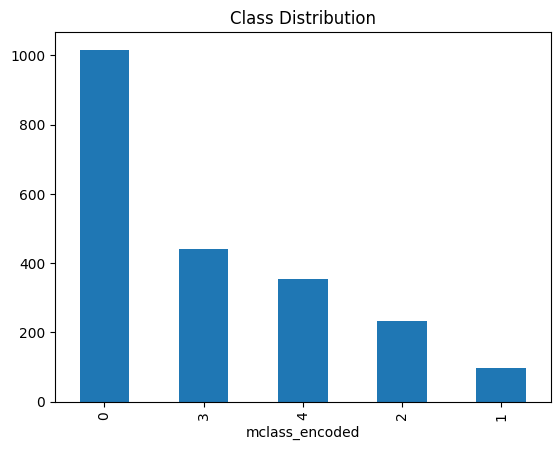

In [15]:
import matplotlib.pyplot as plt
df["mclass_encoded"].value_counts().plot(kind="bar")
plt.title("Class Distribution")
plt.show()
